# Reviewer's rerun
The reviewer asked us to rerun the code after making additional variables for each category. These have been aggregated in a new dataset. In this notebook, we will run our usual analysis including these new variables and see if they pop out as important!

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
import sklearn

In [2]:
# Read in data
africa = pd.read_csv('africa-ML-54_21-03-11.csv')
africa = africa.dropna('columns')
africa=sklearn.utils.shuffle(africa)
labels = africa['sahoStatusEHA']
data = africa.drop(columns=['sahoStatusEHA', 'tempDiffS', 'tempDiff66',
                            'country', 'christCountry', 'cumCasesLag1', 
                            'cumCasesLag1P100KC', 'cumDeathsLag1', 'ebolaCasesN',
                            'gdpPerCap', 'medDocsN']).select_dtypes(['number'])
#data = data.sample()
# Set training size
train_num = 40

# Make data and labels for training and test sets
training_data = data[0:train_num]
training_labels = list(labels[0:train_num])

test_data = data[train_num:]
test_labels = list(labels[train_num:])

<ipython-input-2-5d338811e296>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  africa = africa.dropna('columns')


<ipython-input-3-82b74fe08c5d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array([training_labels, test_labels]) , 3,  histtype='bar', label=['training', 'test'])


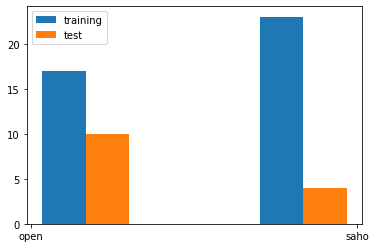

In [3]:
# Make sure that the data is well balanced
plt.hist(np.array([training_labels, test_labels]) , 3,  histtype='bar', label=['training', 'test'])
plt.legend()

## Run Analysis
We now run the analysis using 1000 runs of our random forest

In [4]:
feature_importance = {}
for i in np.arange(1000):
    rf = RandomForestClassifier(n_estimators = 50, max_depth=5, criterion='entropy')
    rf.fit(training_data, training_labels)
    predictions = rf.predict(test_data)
    # Collect 10 most important features
    importance = pd.DataFrame({'feature': training_data.columns, 'importance': np.round(rf.feature_importances_, 3)})
    importance.sort_values('importance', ascending=False, inplace=True)
    importance = importance[:10]
    # Assign values to dictionary
    for imp in importance.values:
        if imp[0] not in feature_importance.keys():
            # If the key is not already there then add it
            feature_importance[imp[0]] = [imp[1]]
        else:
            feature_importance[imp[0]].append(imp[1])

In [5]:
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index')
final_features = feature_importance_df.agg(['mean', 'std', 'sem'], axis=1).sort_values('mean', ascending=False)[:25]
final_features['95-conf'] = 1.96*final_features['sem']
final_features['99-conf'] = 3*final_features['sem']

print(final_features)

                             mean       std       sem   95-conf   99-conf
tempDiffSunfitted        0.061300  0.018491  0.000589  0.001154  0.001767
dayNum                   0.058323  0.018260  0.000583  0.001143  0.001749
prevAdopt                0.042836  0.013385  0.000454  0.000889  0.001361
ciaMedianAge             0.035779  0.009930  0.000385  0.000755  0.001155
SGGENPARLZS              0.033647  0.008347  0.000342  0.000671  0.001027
casesMD                  0.033121  0.008082  0.000346  0.000677  0.001037
WespHvyIndbt             0.031503  0.007176  0.000379  0.000743  0.001138
urbanPop                 0.030396  0.006603  0.000349  0.000683  0.001046
inflation                0.030387  0.006408  0.000336  0.000658  0.001008
ciaPhonesFixed           0.029994  0.006153  0.000349  0.000685  0.001048
ciaObesityAdultPrevRate  0.029046  0.005849  0.000362  0.000710  0.001086
ciaBirthRate             0.029004  0.005824  0.000388  0.000761  0.001165
matMort                  0.028758  0.0

## Check importance features

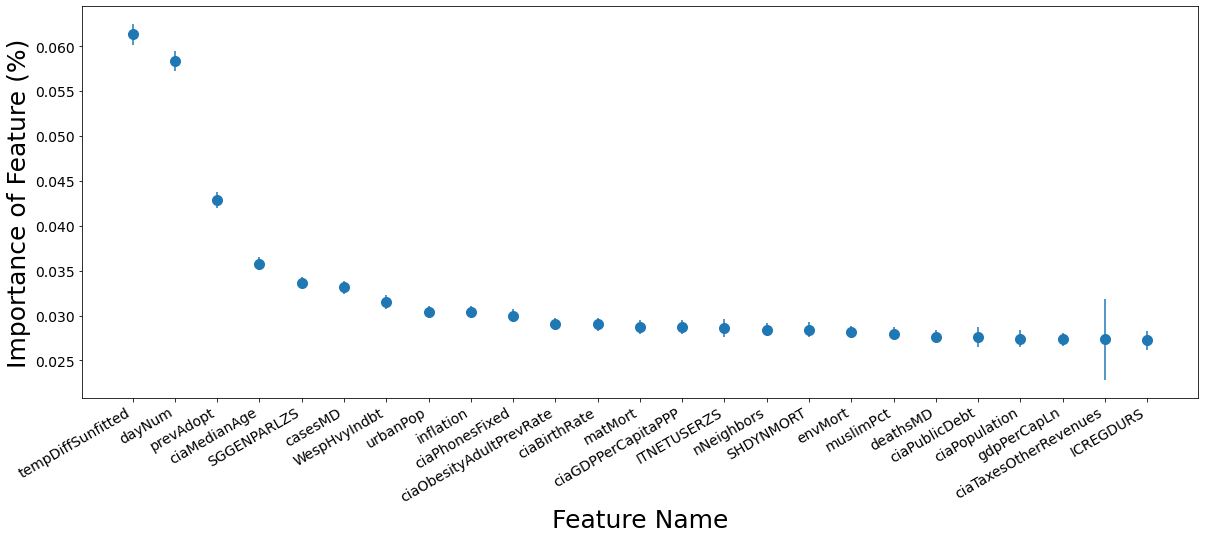

In [6]:
#with plt.xkcd():
fig = plt.figure(figsize=(20,8))
plt.errorbar(final_features.index, 'mean', yerr='95-conf', data=final_features, fmt='o', ms=10)
#plt.xticks(rotation=-60)
fig.autofmt_xdate()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Feature Name', fontsize=25)
plt.ylabel('Importance of Feature (%)', fontsize=25)
plt.savefig('Feature-Importance-AdditionalFactors.png')

In [7]:
predictions = rf.predict(test_data)
print(classification_report(test_labels, predictions, labels=list(set(test_labels))))

              precision    recall  f1-score   support

        open       0.83      0.50      0.62        10
        saho       0.38      0.75      0.50         4

    accuracy                           0.57        14
   macro avg       0.60      0.62      0.56        14
weighted avg       0.70      0.57      0.59        14

